## Keras-ImageDataGenerator

## 『本次練習內容』
#### 學習使用Keras-ImageDataGenerator 與 Imgaug 做圖像增強

## 『本次練習目的』
  #### 熟悉Image Augmentation的實作方法
  #### 瞭解如何導入Imgae Augmentation到原本NN架構中

---

## 第一 Part

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

# 導入ImageDataGenerator到Keras訓練中
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as image_utils
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder

# 練習使用Imgaug
from imgaug import augmenters as iaa

# 打包多種Augmentation
import imgaug as ia

# 包裝自定義Augmentation 與 Imgaug Augmentation
import random

#讀取圖片
img = cv2.imread('D16_Tano.jpg')  
img = cv2.resize(img, (224,224)) # 改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Cv2讀進來是BGR，轉成RGB
img_origin = img.copy()
img = np.array(img, dtype=np.float32)
img_combine = np.array([img,img,img,img], dtype=np.uint8) # 輸入generator要是四維，(224,224,3)變成(4,224,224,3)

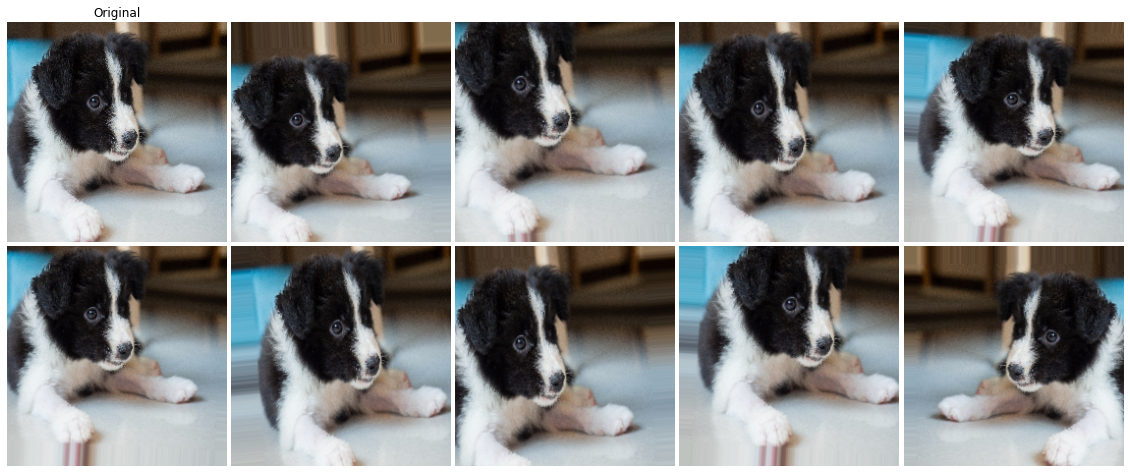

In [2]:
##定義使用的Augmentation
img_gen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False,
                             dtype=np.float32)
width, height, batch_size = 224, 224, 4

batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape == (batch_size, width, height, 3)

plt.figure(figsize=(20,10))
plt.subplot(2, 5, 1, title='Original')
plt.imshow(img_origin) # 原圖
plt.axis('off')
for i, batch in enumerate(batch_gen):
    if i > 8:
        break  # or the generator would loop infinitely
    plt.subplot(2, 5, i+2)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.axis('off')
plt.subplots_adjust(wspace=.02,hspace=-.3)
plt.show()

## 示範如何導入ImageDataGenerator到Keras訓練中

In [3]:
# 使用自己的數據集
# 或參考'https://keras.io/api/preprocessing/image/#imagedatagenerator-class'

# #Training Generator
# train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
# #Test Generator，只需要Rescale，不需要其他增強
# test_datagen = ImageDataGenerator(rescale = 1./255)

# #將路徑給Generator，自動產生Label
# training_set = train_datagen.flow_from_directory('dataset/training_set',
#                                                  target_size = (64, 64),
#                                                  batch_size = 32,
#                                                  class_mode = 'categorical')

# test_set = test_datagen.flow_from_directory('dataset/test_set',
#                                             target_size = (64, 64),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')
    
# #訓練
# history =classifier.fit_generator(training_set,steps_per_epoch = 250,nb_epoch = 25,
#                                   validation_data = valid_set,validation_steps = 63)

# #預測新照片
# test_image = image_utils.load_img('dataset/new_images/new_picture.jpg', target_size=(224, 224))
# test_image = image_utils.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis=0) 

# result = classifier.predict_on_batch(test_image)

---

## 練習使用Imgaug

#### 使用單項增強

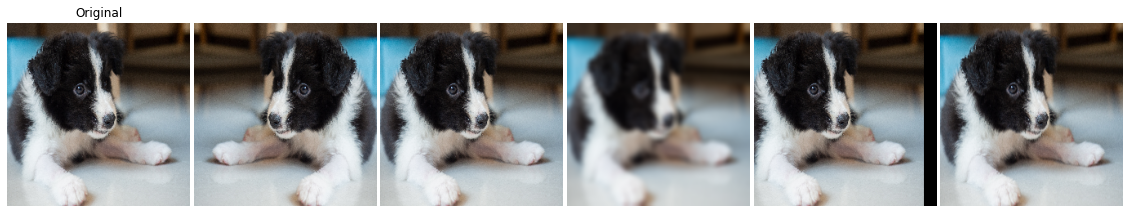

In [4]:
modes = [iaa.Fliplr(1.0), # 水平翻轉機率==1.0
         iaa.Flipud(0.4), # 垂直翻轉機率40%
         iaa.GaussianBlur(3.0), # 高斯模糊圖像( sigma of 3.0)
         iaa.Affine(translate_px={"x": -16}), # 向左橫移16個像素
         iaa.Affine(scale={"y":(0.8, 1.2)})] # 縮放照片，區間(0.8-1.2倍)

plt.figure(figsize=(20,20))
plt.subplot(1, 6, 1, title='Original')
plt.imshow(img_origin.astype(np.uint8))
plt.axis('off')
for i,mode in enumerate(modes):
    plt.subplot(1, 6, i+2)
    plt.imshow(mode.augment_image(img).astype(np.uint8))
    plt.axis('off')
plt.subplots_adjust(wspace=.02)
plt.show()

---

## 第二Part

#### 打包多種Augmentation

#### 請學員自行練習新增以及改變Augmentation內容
#### 可參考Github: https://github.com/aleju/imgaug

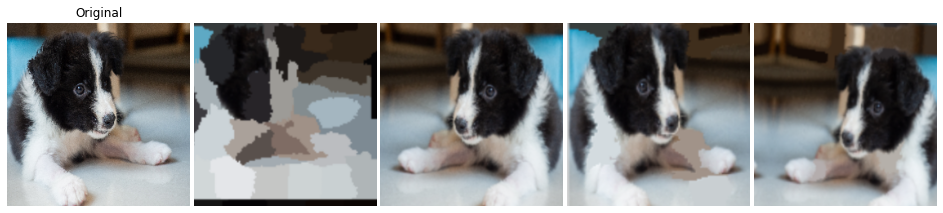

In [5]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug) # Sometimes(0.5, ...) 代表每次都有50%的機率運用不同的Augmentation

##包裝想運用之圖像強化方式
seq = iaa.Sequential([iaa.Crop(px=(0, 16)),
                      iaa.Fliplr(0.4), 
                      sometimes(iaa.CropAndPad(
                          percent=(-0.05, 0.1),
                          pad_mode=ia.ALL,
                          pad_cval=(0, 255)
                          )),
                      sometimes(iaa.Affine(
                          scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
                          translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
                          rotate=(-10, 10),
                          shear=(-8, 8), 
                          order=[0, 1], 
                          cval=(0, 255),
                          mode=ia.ALL 
                          )),
                      sometimes(iaa.Superpixels( # convert images into their superpixel representation
                          p_replace=(0, 1.0),
                          n_segments=(20, 200)
                          )),
                      sometimes(iaa.OneOf([
                          iaa.GaussianBlur((0, 3.0)), # blur images 
                          iaa.AverageBlur(k=(1,3)), # blur image using local means with kernel sizes between 1 and 3
                          iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                          ])),
                      sometimes(iaa.Sharpen( # sharpen images
                          alpha=(0, 0.2),
                          lightness=(0.1, 0.4)
                          )),
                      sometimes(iaa.Emboss( # emboss images
                          alpha=(0, 0.3),
                          strength=(0, 0.5)
                          ))
                     ], random_order=True)

images_aug = seq.augment_images(img_combine) ## Image Augmentation

# 畫出來
plt.figure(figsize=(20,20))
plt.subplot(1, 6, 1, title='Original')
plt.imshow(img_origin.astype(np.uint8))
plt.axis('off')
for i,image in enumerate(images_aug):
    plt.subplot(1, 6, i+2)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
plt.subplots_adjust(wspace=.02)
plt.show()

## 包裝自定義Augmentation 與 Imgaug Augmentation

In [6]:
'''隨機改變亮度'''    
class RandomBrightness(object):
    '''Function to randomly make image brighter or darker
    Parameters
    ----------
    delta: float
        the bound of random.uniform distribution
    '''
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''隨機改變對比'''
class RandomContrast(object):
    '''Function to strengthen or weaken the contrast in each image
    Parameters
    ----------
    lower: float
        lower bound of random.uniform distribution
    upper: float
        upper bound of random.uniform distribution
    '''
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower."
        assert lower >= 0, "contrast lower must be non-negative."
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''包裝所有Augmentation'''
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)
        return image

'''包裝Imgaug'''
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = self.sequence.augment_image(image)
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        #Define imgaug.augmenters Sequential transforms
        sometimes = lambda aug: iaa.Sometimes(0.5, aug) # applies the given augmenter in 50% of all cases

        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1),),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
            ],random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16), #make image brighter or darker
            RandomContrast(0.9, 1.1), #strengthen or weaken the contrast in each image
            ImgAugSequence(img_seq),
            ])
        

    def __call__(self, image):
        image = self.aug_pipeline(image)
        return image

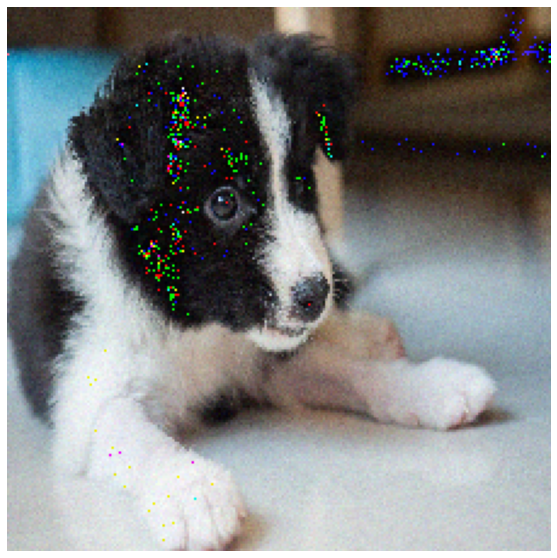

In [7]:
Augmenation=TrainAugmentations()
output = Augmenation(img) 

##畫出來
plt.figure(figsize=(10,10))
plt.imshow(output.astype(np.uint8))
plt.axis('off')
plt.show()

## 鎖住隨機性-主要用在Semantic segmentation中

In [8]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask